Alec Bowen 
Data Challenge 1

In this data set, nine cell features were provided in order to determine whether the cell was cancerous or not. Since the classification of cancerous cells is a binary decision, logistic regression is a sensible first step for fitting a model. I initiially fit a logistic regression model on normalized data and validated it by using a five-fold cross validation. All metrics that I examined (accuracy, precision, and recall) were well above 90 %, indicating that logistic regression works well for this problem. 

I then examined the values of the features to see if any were irrelevant. By using a feature selector, I was able to reduce the number of features down to only three, while still maintaining the same level of accuracy, precision, and recall. 

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [186]:
rawdata = pd.read_csv('cancer.data', names=["id","clump_thickness","size_uniformity","shape_uniformity","adhesion","single_size","bare_nuclei","bland_chromatin","normal_nucleoli","mitoses","class"])

The raw data has some issues. First, some of the data in the bare_nuclei column is missing. Second, the class is defined as 2 for benign and 4 for malignant. I am going to get rid of any row that is missing the bare_nuclei information, then I am going to convert the class column to a binary format, with 0 for benign and 1 for malignant.

In [145]:
# Clean the data by removing all rows with question marks
# Convert class to binary form 
rawdata["class"] = rawdata["class"].apply(lambda x: 1 if x==4 else 0)
data = rawdata[rawdata.bare_nuclei!="?"]
data["bare_nuclei"] = data["bare_nuclei"].apply(lambda x: int(x))

/home/alecbowen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [187]:
#The data is now in the correct format
data

,id,clump_thickness,size_uniformity,shape_uniformity,adhesion,single_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,0
695,841769,2,1,1,1,2,1,1,1,1,0
696,888820,5,10,10,3,7,3,8,10,2,1
697,897471,4,8,6,4,3,4,10,6,1,1


In [188]:
data.groupby('class').count()

,id,clump_thickness,size_uniformity,shape_uniformity,adhesion,single_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
class,,,,,,,,,,
0,444,444,444,444,444,444,444,444,444,444
1,239,239,239,239,239,239,239,239,239,239


Both positive and negative examples of the data are pretty well represented, so I am not going to use any oversampling or undersampling procedures to enhance the data. 

Below I am defining a function that does 5-fold cross validation while keeping track of accuracy, precision, and recall along the way. It will also output the average and stdev of the coefficients.

In [189]:
#Calculate some statistics for my model
#Accuracy and mean absolute error
def cross_validation(x,y,k):
    kf = KFold(n_splits=k,random_state=None,shuffle=True)
    acc = 0.0
    count = 0.0
    prec = 0.0
    rec = 0.0
    num_c = len(x[0])
    coefficients = np.zeros(num_c)
    intercept = 0.0
    for train_index, test_index in kf.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]
        model = LogisticRegression(random_state=None,solver='lbfgs',multi_class='multinomial').fit(x_train,y_train)
        a = model.score(x_test,y_test)
        y_pred = model.predict(x_test)
        p = precision_score(y_test,y_pred)
        r = recall_score(y_test,y_pred)
        acc += a
        prec +=  p
        rec += r
        count += 1
        coefficients += np.array(model.coef_[0])
        intercept += model.intercept_[0]
        #print("Accuracy: ",a)
        #print("Precision: ",p)
        #print("Recall: ", r)
        #print("Coefficients: ",model.coef_)
        #print("Intercepts: ",model.intercept_)
    return [acc/count,prec/count,rec/count,coefficients/count,intercept/count]
        
    
        

Below, I am going to normalize the data, so the logistic regression coefficients are a little easier to interpret. 

In [205]:
X1 = data[["clump_thickness","size_uniformity","shape_uniformity","adhesion","single_size","bare_nuclei","bland_chromatin","normal_nucleoli","mitoses"]]
Y = data["class"]
scaler = StandardScaler()
scaler.fit(X1)
X = scaler.transform(X1)
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

In [206]:
# Five-fold cross-validation
# Identify the coefficients that vary in sign
# They do not produce a strong signal and can be eliminated
acc, prec, rec, coeffs, inter = cross_validation(X,Y,5)
print(acc)
print(prec)
print(rec)

0.9663160154572779
0.9560456697884879
0.9491568627450981


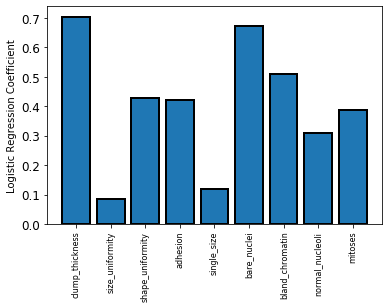

In [192]:
features = ["clump_thickness","size_uniformity","shape_uniformity","adhesion","single_size","bare_nuclei","bland_chromatin","normal_nucleoli","mitoses"]
def make_feature_plot(features,coeffs):
    x_label = np.arange(len(features))
    plt.bar(x_label,coeffs,edgecolor="k",linewidth=2)
    plt.tick_params(axis="both",which="major",labelsize=12)
    plt.xticks(x_label,features,fontsize=8,rotation="vertical")
    plt.ylabel("Logistic Regression Coefficient")
    plt.show()
    
make_feature_plot(features,coeffs)

The above plot shows the relative importance of the separate features within the logistic regression model. clump_thickness seems to have the biggest effect on the outcome followed by bare_nuclei. size_uniformity appears to have the smallest effect. Now I will use a feature selector to see if there is anything worth eliminating, as in it has very little effect on the fit if it is removed.  

In [193]:
lg = LogisticRegression(random_state=None,solver='lbfgs',multi_class='multinomial').fit(X,Y)


In [194]:
def stats_for_features(lg,x,y,thresh):
    slg = SelectFromModel(lg,threshold=thresh)
    slg.fit(X,Y)
    X_red = slg.transform(X)
    n = X_red.shape[1]
    acc, prec, rec, coeffs, inter = cross_validation(X_red,Y,5)
    feature_idx = slg.get_support()
    feature_idx = np.insert(feature_idx,0,False)
    feature_idx = np.append(feature_idx,False)
    print("Number of Features",n)
    print("Accuracy: ",acc)
    print("Precision: ",prec)
    print("Recall", rec)
    return n,acc,prec,rec,coeffs,feature_idx

In [195]:
stats_for_features(lg,X,Y,0.25)

Number of Features 7
Accuracy:  0.9678080721339631
Precision:  0.9576086956521739
Recall 0.950142136109126


(7,
 0.9678080721339631,
 0.9576086956521739,
 0.950142136109126,
 array([0.7068007 , 0.51894351, 0.46547558, 0.69016305, 0.53884018,
        0.35059013, 0.39377368]),
 array([False,  True, False,  True,  True, False,  True,  True,  True,
         True, False]))

In [196]:
stats_for_features(lg,X,Y,0.5)

Number of Features 3
Accuracy:  0.9619579218548733
Precision:  0.9537810654036507
Recall 0.9377139914349216


(3,
 0.9619579218548733,
 0.9537810654036507,
 0.9377139914349216,
 array([1.05042914, 1.00817567, 0.92126104]),
 array([False,  True, False, False, False, False,  True,  True, False,
        False, False]))

In [197]:
stats_for_features(lg,X,Y,0.6)

Number of Features 2
Accuracy:  0.9472735079433233
Precision:  0.9465938589793854
Recall 0.8980897465705648


(2,
 0.9472735079433233,
 0.9465938589793854,
 0.8980897465705648,
 array([1.1808992 , 1.36431242]),
 array([False,  True, False, False, False, False,  True, False, False,
        False, False]))

In [198]:
n,acc,prec,rec,coeffs,feature_idx = stats_for_features(lg,X,Y,0.5)

Number of Features 3
Accuracy:  0.963439244310863
Precision:  0.9498956916099773
Recall 0.9454812185743864


I can get down to three features with almost no sacrifice in accuracy, precision, or recall. I am going to plot the coefficients from using only these three.

In [199]:
features2 = list(data.columns[feature_idx])

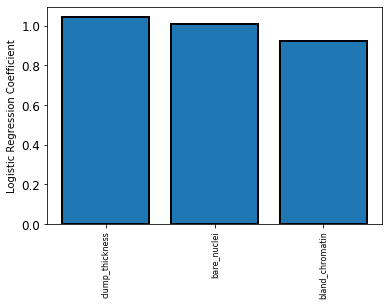

In [200]:
make_feature_plot(features2,coeffs)

One final check to make sure I have done everything correctly: I'm going to fit a new model only on these features and see if it does well in cross validation.

In [207]:
X1 = data[["clump_thickness","bare_nuclei","bland_chromatin"]]
#X1
Y = data["class"]
scaler = StandardScaler()
scaler.fit(X1)
X = scaler.transform(X1)
#X

In [209]:
acc, prec, rec, coeffs, inter = cross_validation(X,Y,5)
print(acc)
print(prec)
print(rec)

0.9634070416487763
0.9526537945937295
0.9410450277823724


There is effectively no change in the accuracy, precision, and recall using only these three features as compared to using the full set.

In conclusion, a simple logistic regression model on this data provides a high accuracy, high precision, and high recall predictor of cell malignancy using only three features from the initial data set. This model is nice because it has high explanatory power, showing that the three highlighted features are sufficient to indicate malignancy in about 95% of cases. 